In [1]:
import os
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tifffile as tiff 
from tqdm.auto import tqdm

In [2]:
import torch
import torchvision
from torch.utils.data import Dataset as Basedataset
from torch.utils.data import DataLoader
import albumentations as albu
from albumentations.pytorch import ToTensorV2

## Exploring data

In [3]:
train_table = pd.read_csv('../input/hubmap-organ-segmentation/train.csv')
test_table = pd.read_csv('../input/hubmap-organ-segmentation/test.csv')

In [4]:
train_table.head()

id     organ data_source  img_height  img_width  pixel_size  \
0  10044  prostate         HPA        3000       3000         0.4   
1  10274  prostate         HPA        3000       3000         0.4   
2  10392    spleen         HPA        3000       3000         0.4   
3  10488      lung         HPA        3000       3000         0.4   
4  10610    spleen         HPA        3000       3000         0.4   

   tissue_thickness                                                rle   age  \
0                 4  1459676 77 1462675 82 1465674 87 1468673 92 14...  37.0   
1                 4  715707 2 718705 8 721703 11 724701 18 727692 3...  76.0   
2                 4  1228631 20 1231629 24 1234624 40 1237623 47 12...  82.0   
3                 4  3446519 15 3449517 17 3452514 20 3455510 24 34...  78.0   
4                 4  478925 68 481909 87 484893 105 487863 154 4908...  21.0   

      sex  
0    Male  
1    Male  
2    Male  
3    Male  
4  Female

In [5]:
test_table.head()

id   organ data_source  img_height  img_width  pixel_size  \
0  10078  spleen      Hubmap        2023       2023      0.4945   

   tissue_thickness  
0                 4

**rle** - The target column. A run length encoded copy of the annotations. Provided for the training set only.

In [6]:
data_path = Path('/kaggle/input/hubmap-organ-segmentation')
files = [f.name for f in list(data_path.glob('*'))]

## Displaying images

In [7]:
def view_images(imgs, titles, rows, cols, masks = None):
    
    color=(255, 0, 0)
    br=0.5
    figsize=(20, 20)
    
    
    assert(len(imgs) == len(titles) == rows*cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    for idx, (ax, img, title) in enumerate(zip(axes.ravel(), imgs, titles)):
        ax.set_title(title)
        draw_img = img.copy()
        if masks:
            mask = masks[idx].astype(bool)
            color_arr = np.zeros(draw_img.shape) + color
            draw_img[mask] = draw_img[mask]*(1 - br) + color_arr[mask]*br
            draw_img.astype(np.uint8)
        ax.imshow(draw_img)

    plt.show()

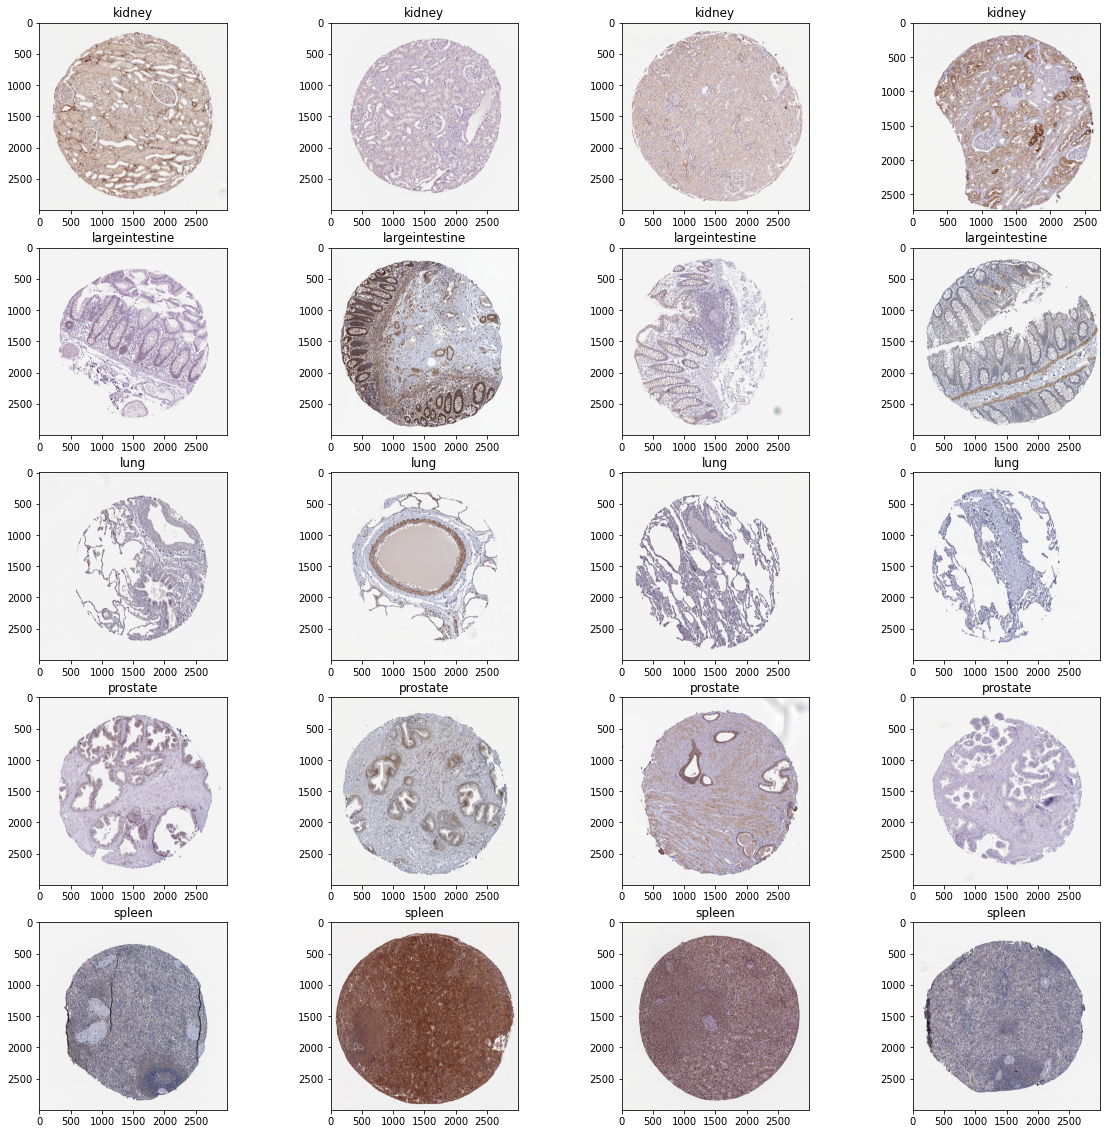

In [8]:
img_path = data_path / 'train_images'
imgs, titles = [], []
labels = ['kidney', 'largeintestine', 'lung', 'prostate', 'spleen']
rows, cols = len(labels), 4

for r in range(rows):
    for c in range(cols):
        _df = train_table[train_table['organ'] == labels[r]].iloc[c]
        
        im = img_path / f"{_df.id}.tiff"
        img = cv2.imread(str(im))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        imgs.append(img)
        titles.append(_df.organ)
        
view_images(imgs, titles, rows, cols)

## Displaying Masks

In [9]:
def rletomask(rle, size):
    rle = np.array(list(map(int, rle.split())))
    mask = np.zeros((size*size))
    for start, end in zip(rle[::2], rle[1::2]):
        mask[start:start+end] = 1

    return mask.reshape(size,size).T

In [10]:
imgs, titles, masks = [], [], []
for r in range(rows):
    for c in range(cols):
        _df = train_table[train_table['organ']==labels[r]].iloc[c]
        
        im = img_path / f"{_df.id}.tiff"
        img = cv2.imread(str(im))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = rletomask(_df.rle, _df.img_width)
        
        imgs.append(img)
        titles.append(_df.organ)
        masks.append(mask)

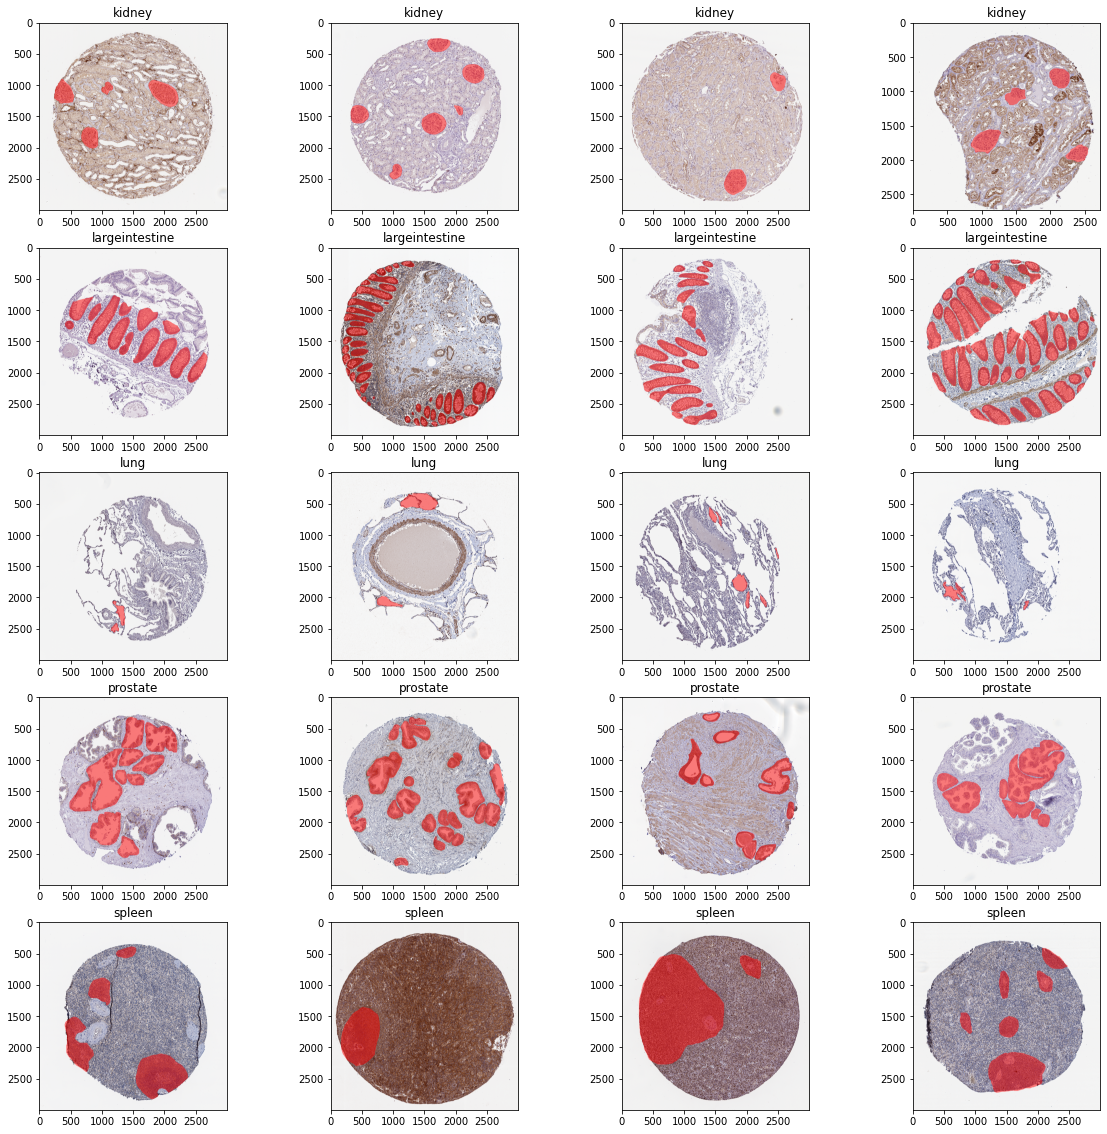

In [11]:
view_images(imgs, titles, rows, cols, masks)

## Create dataset

In [12]:
class Dataset(Basedataset):
    def __init__(self, df : pd.DataFrame, img_path : Path, transform : callable = None, return_class : bool = False):
        self.df = df
        self.img_path = img_path
        self.transform = transform
        self.return_class = return_class
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        im = self.img_path / f"{self.df['id'].iloc[idx]}.tiff"
        img = cv2.imread(str(im))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = rletomask(rle = self.df['rle'].iloc[idx], size = self.df['img_width'].iloc[idx])
        mask = np.expand_dims(mask, axis=2)
        
        if self.transform:
            augment = self.transform(image = img, mask = mask)
            img, mask = augment['image'], augment['mask']
            
        if self.return_class:
            return img, mask, self.df['organ'].iloc[idx]
        
        return img, mask

In [13]:
crop = 448

toy_dataset = Dataset(
    df = train_table,
    img_path = img_path,
    transform = albu.Compose([
        albu.PadIfNeeded(min_height=crop, min_width=crop),
        albu.CropNonEmptyMaskIfExists(height=crop, width=crop),
        albu.Flip(),
    ]),
    return_class = True
)

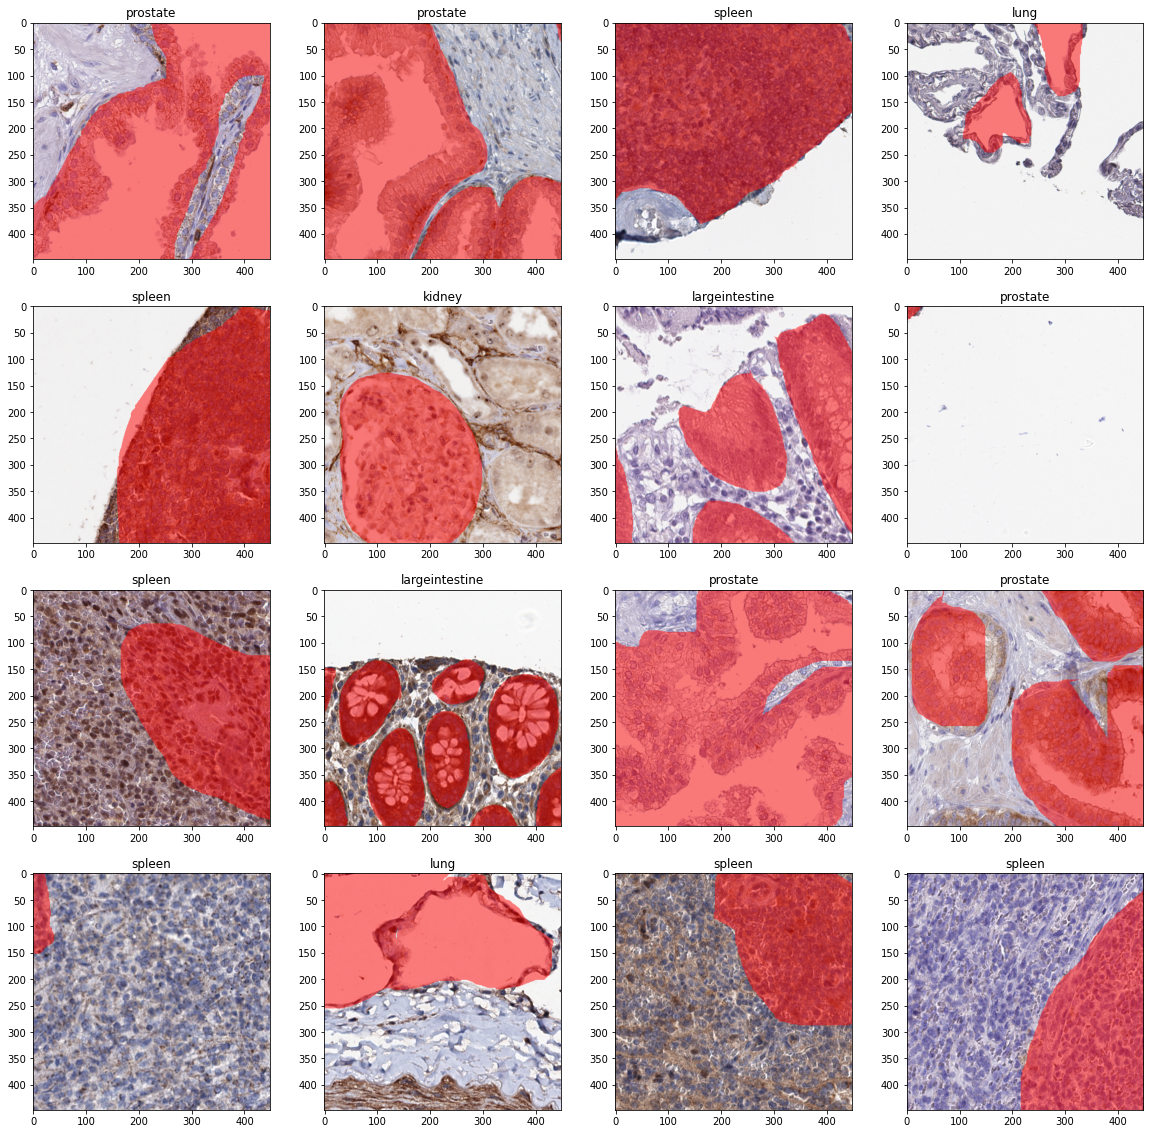

In [14]:
imgs, titles, masks = [], [], []
rows, cols = 4, 4

for r in range(rows):
    for c in range(cols):
        
        img, mask, label = toy_dataset[r*rows + c]
        
        imgs.append(img)
        titles.append(label)
        masks.append(mask[:, :, 0])
        
view_images(imgs, titles, 
            rows, cols, 
            masks = masks)